In [19]:
%load_ext autoreload
%autoreload 2
import numpy as np; np.set_printoptions(precision=4); np.random.seed(0)
import torch; torch.set_printoptions(precision=4)
seed = 1

torch.manual_seed(seed)
import torch.nn as nn
import matplotlib.pyplot as plt; plt.rc('font', size=12); 
import matplotlib 
from matplotlib.font_manager import FontProperties
from mpl_toolkits import mplot3d
import matplotlib.pylab as pl
import seaborn as sns
import time
import sys
import itertools
import random; random.seed(0)
import scipy
import os
import warnings

from textwrap import wrap
from scipy.stats import wilcoxon
from sklearn.metrics.pairwise import cosine_similarity

sys.path.append("../two_module_rnn/code")
os.chdir('/home/yl4317/Documents/two_module_rnn/code')
from model_working import *
from functions import *
os.chdir('/home/yl4317/Documents/two_module_rnn/')

print(torch.__version__)
print(sys.version)
                
%matplotlib inline

torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True) 
torch.backends.cudnn.deterministic = True    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.13.1+cu116
3.10.8 (main, Nov 24 2022, 14:13:03) [GCC 11.2.0]


# Generate data for dendritic branch coding

In [21]:
start = time.time()

all_data_branch_coding = []

for model_name in sorted(os.listdir('/scratch/yl4317/two_module_rnn/saved_models/')):
#     if '2022-09-09-12-23-36' in model_name and 'wcst' in model_name and 'success' in model_name:
#     if ('2022-09-19' in model_name or '2022-09-20' in model_name or '2022-09-22' in model_name or '2022-10-05' in model_name or '2022-10-11' in model_name) and 'wcst' in model_name and 'success' in model_name:
    if ('2023-05-01' in model_name or '2023-05-10' in model_name) and 'success' in model_name:
#     if 'pfc_only_to_srvipsst_sparse_srsst_to_sredend' in model_name and 'wcst' in model_narule_sel_unnorm_1_all model_name:
#         if '2022-09-20-17-30-17_wcst_48_' not in model_name:
#             continue
        print(model_name)
        
        # load model
        path_to_file = '/scratch/yl4317/two_module_rnn/saved_models/'+model_name
        with HiddenPrints():
            model, hp_test, hp_task_test, optim, saved_data = load_model_v2(path_to_file=path_to_file,model_name=model_name, simple=False, plot=False, toprint=False)
            # add filter here
        if hp_test['dt']!=10:
            continue
#         if hp_test['sparse_srsst_to_sredend']!=0.8:
#             continue
#         print('sparsity of SR SST to SR Edend: {}'.format(hp_test['sparse_srsst_to_sredend']))
#         if len(hp_test['cell_group_list'])==2:
#             print('pass\n')
#             continue
        if hp_test['dend_nonlinearity'] not in ['divisive_2', 'subtractive']:
            print('pass')
            continue
                
        
        # make noiseless
#         model.rnn.network_noise = 0
#         hp_test['input_noise_perceptual'] = 0
#         hp_test['input_noise_rule'] = 0
        
        # generate some neural data
#         neural_data = generate_neural_data_test(model=model, n_trials_test=100, switch_every_test=5, to_plot=False, hp_test=hp_test, hp_task_test=hp_task_test, compute_current=False)
        if '{}_testdata_noiseless_no_current_matrix'.format(model_name) not in os.listdir('/scratch/yl4317/two_module_rnn/saved_testdata/'):
            print('did not find testing data, pass\n')
            continue
        with open('/scratch/yl4317/two_module_rnn/saved_testdata/{}_testdata_noiseless_no_current_matrix'.format(model_name), 'rb') as f:
            neural_data = pickle.load(f)
        test_data = neural_data['test_data']
        rnn_activity = neural_data['rnn_activity'].detach().cpu().numpy()
        if np.isnan(rnn_activity).any():
            print('NaN in rnn_activity, pass\n')
            continue
#         current_matrix = neural_data['current_matrix']
        
        mean_perf = np.mean(np.array(test_data['perfs']))
        mean_perf_rule = np.mean(np.array(test_data['perf_rules']))
        if mean_perf<=0.8 or mean_perf_rule<=0.8:
            print('This model performance is low!! {}/{}\n'.format(mean_perf, mean_perf_rule))
            continue
            
        # generate trial labels
        trial_labels = label_trials_wcst(test_data=test_data)
        if len(trial_labels['rule1_trs_stable'])==0 or len(trial_labels['rule2_trs_stable'])==0:
            print('no rule 1 or 2 trials, pass\n')
            continue
        resp_trs_stable = {'c1': trial_labels['c1_trs_stable'], 'c2': trial_labels['c2_trs_stable'], 'c3': trial_labels['c3_trs_stable']}
        # compute cell selectivity
        all_sels = compute_sel_wcst(rnn_activity=rnn_activity, hp=hp_test, hp_task=hp_task_test, rules=test_data['rules'],
                                     rule1_trs_stable=trial_labels['rule1_trs_stable'], rule2_trs_stable=trial_labels['rule2_trs_stable'],
                                     rule1_trs_after_error = trial_labels['rule1_trs_after_error'], rule2_trs_after_error = trial_labels['rule2_trs_after_error'],
                                     resp_trs_stable=resp_trs_stable, trs_by_center_card=trial_labels['trs_by_center_card_stable'],
                                     stims=test_data['stims'], error_trials=trial_labels['error_trials'], trial_labels=trial_labels)
        rule_sel_norm = all_sels['rule_normalized_activity']
        rule_sel_unnorm = all_sels['rule_activity']
        
        ## analysis 1
        dend1_idx = np.arange(model.rnn.cg_idx['sr_edend'][0], model.rnn.cg_idx['sr_edend'][0]+len(model.rnn.cg_idx['sr_esoma']))
        dend2_idx = [n for n in model.rnn.cg_idx['sr_edend'] if n not in dend1_idx]
        
        
        rule_sel_dend1_norm = [rule_sel_norm[n] for n in dend1_idx]
        rule_sel_dend2_norm = [rule_sel_norm[n] for n in dend2_idx]
        rule_sel_dend1_unnorm = [rule_sel_unnorm[n] for n in dend1_idx]
        rule_sel_dend2_unnorm = [rule_sel_unnorm[n] for n in dend2_idx]
        
        mean_act = np.mean(rnn_activity, axis=(0,1,2))
        
        ## analysis 2
        subcg_sr_idx = define_subpop_sr_wcst(model=model, hp_task=hp_task_test, hp=hp_test, rnn_activity=rnn_activity, 
                                          rule_sel=all_sels['rule_normalized_activity'], resp_sel=all_sels['resp_normalized'], ref_card_sel=all_sels['ref_card_normalized'],
                                          rule1_trs_stable=trial_labels['rule1_trs_stable'], 
                                          rule2_trs_stable=trial_labels['rule2_trs_stable'], 
                                          rule_threshold=0, resp_threshold=0)
        for subcg in subcg_sr_idx.keys():
            model.rnn.cg_idx['subcg_sr_'+subcg] = subcg_sr_idx[subcg]
        
        mean_rule_sel_all_sm_esoma = np.mean([all_sels['rule_normalized_activity'][n] for n in model.rnn.cg_idx['sr_esoma']])
        sr_esoma_rule_cell_idx = np.concatenate((model.rnn.cg_idx['subcg_sr_rule1_sr_esoma'], model.rnn.cg_idx['subcg_sr_rule2_sr_esoma']))
        mean_rule_sel_all_sm_esoma_rule_cells = np.mean([all_sels['rule_normalized_activity'][n] for n in sr_esoma_rule_cell_idx])
        
        ## analysis 3, cosine similarity between the mean activity vector during the two rules
        mean_state_rule1 = rnn_activity[trial_labels['rule1_trs_stable'], :, 0, :][:, :, model.rnn.cg_idx['sr_esoma']]
        mean_state_rule1 = np.mean(mean_state_rule1, axis=(0, 1))
        mean_state_rule2 = rnn_activity[trial_labels['rule2_trs_stable'], :, 0, :][:, :, model.rnn.cg_idx['sr_esoma']]
        mean_state_rule2 = np.mean(mean_state_rule2, axis=(0, 1))
        cosine = cosine_similarity(X=mean_state_rule1.reshape(1, -1), Y=mean_state_rule2.reshape(1, -1))
        
        all_data_branch_coding.append({'model': model, 
                                       'model_name': model_name, 
                                       'hp': hp_test, 
                                       'rule_sel_dend1_norm': rule_sel_dend1_norm, 
                                       'rule_sel_dend2_norm': rule_sel_dend2_norm, 
                                       'rule_sel_dend1_unnorm': rule_sel_dend1_unnorm, 
                                       'rule_sel_dend2_unnorm': rule_sel_dend2_unnorm, 
#                                        'rule_sel': rule_sel_used, 
                                       'act_rule1': all_sels['act_rule1'],
                                       'act_rule2': all_sels['act_rule2'], 
                                       'mean_act': mean_act, 
                                       'all_sels': all_sels,
#                                        'mean_rule_sel_all_sm_esoma': mean_rule_sel_all_sm_esoma,
#                                        'mean_rule_sel_all_sm_esoma_rule_cells': mean_rule_sel_all_sm_esoma_rule_cells,
#                                        'cosine': cosine,
                                       'dend1_idx': dend1_idx,
                                       'dend2_idx': dend2_idx,
                                       'subcg_sr_idx': subcg_sr_idx})
        
print(time.time()-start)
with open('branch_coding.pickle', 'wb') as f:
    pickle.dump(all_data_branch_coding, f)

success_2023-05-01-09-44-09_wcst_100_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_107_final_maybe
NaN in rnn_activity, pass

success_2023-05-01-09-44-09_wcst_116_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_125_final_maybe
This model performance is low!! 0.3112500011920929/0.3125

success_2023-05-01-09-44-09_wcst_128_final_maybe
This model performance is low!! 0.3449999988079071/0.5874999761581421

success_2023-05-01-09-44-09_wcst_130_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_131_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_133_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_135_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_136_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_137_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_139_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_141_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_142_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_145_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_150_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_153_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_161_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_166_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_176_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_179_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_17_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_181_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_182_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_184_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_18_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_190_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_199_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_23_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_29_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_38_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_39_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_40_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_41_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_43_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_45_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_46_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_48_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_49_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_55_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_63_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_66_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_68_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_69_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_77_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_78_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_79_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_80_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_81_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_83_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_85_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_86_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_87_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_88_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_89_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_90_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_91_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_93_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_95_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_96_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-01-09-44-09_wcst_98_final_maybe


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_105_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_106_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_10_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_112_sparsity0
NaN in rnn_activity, pass

success_2023-05-10-14-28-42_wcst_115_sparsity0
NaN in rnn_activity, pass

success_2023-05-10-14-28-42_wcst_116_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_118_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_121_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_122_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_124_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_126_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_131_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_134_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_136_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_139_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_142_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_143_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_144_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_149_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_150_sparsity0
NaN in rnn_activity, pass

success_2023-05-10-14-28-42_wcst_151_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_156_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_165_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_16_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_170_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_172_sparsity0
NaN in rnn_activity, pass

success_2023-05-10-14-28-42_wcst_176_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_177_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_179_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_17_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_180_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_183_sparsity0
NaN in rnn_activity, pass

success_2023-05-10-14-28-42_wcst_189_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_18_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_197_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_19_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_200_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_20_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_21_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_23_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_26_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_42_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_43_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_44_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_50_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_57_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_58_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_5_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_60_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_63_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_6_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_7_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_82_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_86_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_87_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_93_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

success_2023-05-10-14-28-42_wcst_98_sparsity0


/home/yl4317/Documents/two_module_rnn/code/functions.py:2584: RuntimeWarning: invalid value encountered in divide
  act_rule1_time = np.mean(rnn_activity[rule1_trs_stable, :, 0, n], axis=0)
/home/yl4317/Documents/two_module_rnn/code/functions.py:2594: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_fdbk = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, fdbk_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2598: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_iti = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, iti_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2602: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_ref_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, ref_card_ts])
/home/yl4317/Documents/two_module_rnn/code/functions.py:2606: RuntimeWarning: invalid value encountered in scalar divide
  act_rule1_test_card = np.mean(rnn_activity[rule1_trs_stable, :, 0, n][:, test_

505.3346197605133


# Figure 7b, c: rule selectivity on different branches across different sparsity levels

In [ ]:
with open('/home/yl4317/Documents/two_module_rnn/processed_data/branch_coding.pickle', 'rb') as handle:
    all_data_branch_coding = pickle.load(handle)
    
all_dend_nonlinears = sorted(list(set(x['hp']['dend_nonlinearity'] for x in all_data_branch_coding)))
all_sparsitys = sorted(list(set(x['hp']['sparse_srsst_to_sredend'] for x in all_data_branch_coding)))

data_fig7b = {'x': [], 'y': []}    # rule selectivity of two branches, for fully-connected SST -> exc 
data_fig7c = {'x': [], 'y': []}    # rule selectivity of two branches, for 20% connected SST -> exc 

for dend_nonlinear in all_dend_nonlinears:
    for sparsity in all_sparsitys:
        if not ((dend_nonlinear == 'subtractive' and sparsity == 0) or (dend_nonlinear == 'subtractive' and sparsity == 0.8)):
            continue
        fig, ax = plt.subplots(1, 1, figsize=[14, 7])
        fig.patch.set_facecolor('white')
        fig.suptitle('Rule selectivity for the two branches, \nacross all models, {} {}'.format(sparsity, dend_nonlinear), fontsize=20)
        ax.set_xlabel('Rule selectivity of \none dendritic branch', fontsize=20)
        ax.set_ylabel('Rule selectivity of \nthe other dendritic branch', fontsize=20)
        ax.set_xlim([-1, 1])
        ax.set_ylim([-1, 1])
        for x in all_data_branch_coding:
            if x['hp']['sparse_srsst_to_sredend']!=sparsity or (x['hp']['dend_nonlinearity']!=dend_nonlinear):
                continue
            
            for n in range(70):
                dend1_idx = n+70    # id of one dendritic branch
                dend2_idx = n+140    # the other branch
                ax.scatter(x=x['rule_sel_dend1_norm'][n], y=x['rule_sel_dend2_norm'][n], s=30, color='k', alpha=1)
                ax.axvline(x=0, linestyle='dotted', color='k')
                ax.axhline(y=0, linestyle='dotted', color='k')
                ax.set_xlim([-1.1, 1.1])
                ax.set_ylim([-1.1, 1.1])
            
                # source data
                if dend_nonlinear == 'subtractive' and sparsity == 0:
                    data_fig7b['x'].append(x['rule_sel_dend1_norm'][n])
                    data_fig7b['y'].append(x['rule_sel_dend2_norm'][n])
                if dend_nonlinear == 'subtractive' and sparsity == 0.8:
                    data_fig7c['x'].append(x['rule_sel_dend1_norm'][n])
                    data_fig7c['y'].append(x['rule_sel_dend2_norm'][n])

        
        for i in range(2):
            make_pretty_axes(ax[i])
        fig.tight_layout()
        plt.show()
        fig.savefig('/home/yl4317/Documents/two_module_rnn/figs/dend_rule_coding_sparsity{}_{}.pdf'.format(sparsity, dend_nonlinear))
# save to csv
pd.DataFrame.from_dict(data=data_fig7b, orient='columns').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/fig7b_dend_coding_dense.csv', header=False)
pd.DataFrame.from_dict(data=data_fig7c, orient='columns').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/fig7c_dend_coding_sparse.csv', header=False)

# Figure 7d: branch coding as a function of sparsity of SST->Edend

subtractive


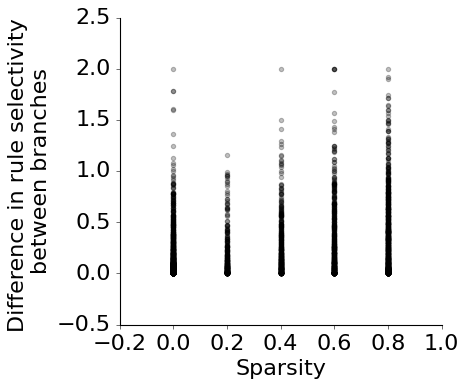

subtractive, 0.8, n=980
subtractive, 0.6000000000000001, n=560
subtractive, 0.4, n=490
subtractive, 0.2, n=350
subtractive, 0.0, n=1890


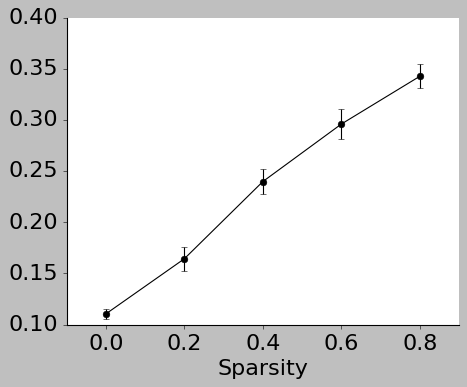

divisive_2


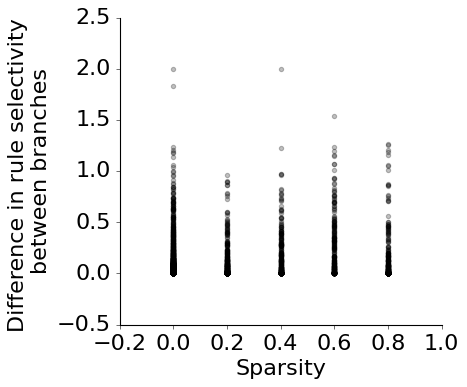

divisive_2, 0.8, n=350
divisive_2, 0.6000000000000001, n=280
divisive_2, 0.4, n=350
divisive_2, 0.2, n=490
divisive_2, 0.0, n=1960


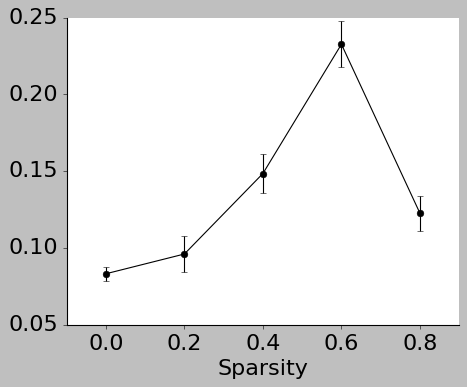

In [26]:
# branch coding as a function of sparsity of SST->Edend
import scipy.stats as stats
all_dend_nonlinears = list(set(x['hp']['dend_nonlinearity'] for x in all_data_branch_coding))


data_fig7d = {'x': [], 'y': [], 'y_err': []}
data_suppfig11a = {'x': [], 'y': [], 'y_err': []}


for dend_nonlinear in all_dend_nonlinears:
    print(dend_nonlinear)
    plt.rc('font', size=12)
    fig, ax = plt.subplots(figsize=[6, 5])
    fig.patch.set_facecolor('white')
#     fig.suptitle('Difference between the rule selectivity for the two branches, \nas a function of the sparsity from SM SST to SR Edend', fontsize=20)
    ax.set_xlabel('Sparsity', fontsize=20)
    ax.set_ylabel('Difference in rule selectivity \nbetween branches', fontsize=20)
    for x in all_data_branch_coding:
        if x['hp']['dend_nonlinearity']!=dend_nonlinear:
            continue
        n_dends = len(x['rule_sel_dend1_norm'])
    #     for n in range(n_dends):
        diff_rulesel = np.abs(np.array(x['rule_sel_dend1_norm']) - np.array(x['rule_sel_dend2_norm']))
#         print(x['rule_sel_dend1_unnorm'][0], x['rule_sel_dend1_norm'][0])
        ax.scatter(x=x['hp']['sparse_srsst_to_sredend']*np.ones(n_dends), y=diff_rulesel, s=15, color='k', alpha=0.25)
    ax.tick_params(axis='both', which='major', labelsize=20)
    make_pretty_axes(ax)
    fig.tight_layout()
    plt.show()

    sparsities = sorted(list(set([x['hp']['sparse_srsst_to_sredend'] for x in all_data_branch_coding])), reverse=True)
    sparsity_vs_diffrulesel = dict.fromkeys(sparsities)
    for s in sparsities:
        sparsity_vs_diffrulesel[s] = {}              
        all_diff_rulesel = []
        for x in all_data_branch_coding:
#             if x['hp']['initialization_weights']!='kaiming_uniform':
#                 continue
            if x['hp']['dend_nonlinearity']!=dend_nonlinear:
                continue
            if x['hp']['sparse_srsst_to_sredend']==s:
#                 if np.isnan(x['rule_sel_dend1']).any()==True or np.isnan(x['rule_sel_dend2']).any()==True:
#                     print('nan!')
#                     print(x['rule_sel_dend1'], x['rule_sel_dend2'])
#                     continue
#                 print(np.array(x['rule_sel_dend1_norm']), np.array(x['rule_sel_dend2_norm']))
                all_diff_rulesel.extend(np.abs(np.array(x['rule_sel_dend1_norm']) - np.array(x['rule_sel_dend2_norm'])))
        mean_diff_rulesel = np.mean(all_diff_rulesel)
        print('{}, {}, n={}'.format(dend_nonlinear, s, len(all_diff_rulesel)))
        std_diff_rulesel = np.std(all_diff_rulesel)
        sem_diff_rulesel = stats.sem(all_diff_rulesel)
        sparsity_vs_diffrulesel[s]['mean_diff_rulesel'] = mean_diff_rulesel
        sparsity_vs_diffrulesel[s]['std_diff_rulesel'] = std_diff_rulesel
        sparsity_vs_diffrulesel[s]['sem_diff_rulesel'] = sem_diff_rulesel
    
#     if dend_nonlinear=='v2_std':
#         print(sparsity_vs_diffrulesel)

    #===== Plotting =====#
    fig, ax = plt.subplots(figsize=[6, 5])   
    x = sparsities
    y = [sparsity_vs_diffrulesel[s]['mean_diff_rulesel'] for s in sparsities]
    y_err = [sparsity_vs_diffrulesel[s]['sem_diff_rulesel'] for s in sparsities]
    ax.errorbar(x=x, y=y, yerr=yerr, marker='o', color='k')
    ax.set_xlim([min(sparsities)-0.1, max(sparsities)+0.1])
    ax.set_xlabel('Sparsity', fontsize=20)
#     ax[1].set_ylabel('Mean difference in rule \nselectivity between branches', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=20)
    make_pretty_axes(ax)
    fig.tight_layout()
    plt.show()
    fig.savefig('/home/yl4317/Documents/two_module_rnn/figs/dend_rule_coding_{}.pdf'.format(dend_nonlinear))

    if dend_nonlinear == 'subtractive':
        data_fig7d['x'] = x
        data_fig7d['y'] = y
        data_fig7d['y_err'] = y_err
    elif dend_nonlinear == 'divisive_2':
        data_suppfig11a['x'] = x
        data_suppfig11a['y'] = y
        data_suppfig11a['y_err'] = y_err

# save to csv
pd.DataFrame.from_dict(data=data_fig7d, orient='columns').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/fig7d_dend_coding_subtractive.csv', header=False)
pd.DataFrame.from_dict(data=data_suppfig11a, orient='columns').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/suppfig11a_dend_coding_subtractive.csv', header=False)

# sparsity effect, plot the nonlinearities together

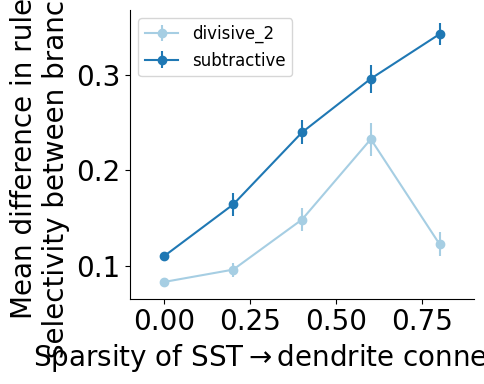

In [5]:
# plot the nonlinearities together
import scipy.stats as stats

sparsities = sorted(list(set(x['hp']['sparse_srsst_to_sredend'] for x in all_data_branch_coding)))
dend_nonlinears = sorted(list(set(x['hp']['dend_nonlinearity'] for x in all_data_branch_coding)))
dendnonlinear_and_sparsity_vs_branchcoding = dict.fromkeys(list(itertools.product(sparsities, dend_nonlinears)))

colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c']
dend_color_dict = dict(zip(dend_nonlinears, colors))

for key in dendnonlinear_and_sparsity_vs_branchcoding.keys():
    dendnonlinear_and_sparsity_vs_branchcoding[key] = []

for x in all_data_branch_coding:
    
    # add filters
#     if x['hp']['no_pfcesoma_to_srsst']==True:
#         continue
        
    sparsity = x['hp']['sparse_srsst_to_sredend']
    dend_nonlinear = x['hp']['dend_nonlinearity']
    dendnonlinear_and_sparsity_vs_branchcoding[(sparsity, dend_nonlinear)].extend(np.abs(np.array(x['rule_sel_dend1_norm']) - np.array(x['rule_sel_dend2_norm'])))
#     unnorm_rule_sel_dend1 = (x['act_rule1']-x['act_rule2'])[70:140]
#     unnorm_rule_sel_dend2 = (x['act_rule1']-x['act_rule2'])[140:210]
#     dendnonlinear_and_sparsity_vs_branchcoding[(sparsity, dend_nonlinear)].extend(np.abs(unnorm_rule_sel_dend1 - unnorm_rule_sel_dend2))

fig, ax = plt.subplots(figsize=[5, 4])
fig.patch.set_facecolor('white')
for dend_nonlinear in dend_nonlinears:
#     if dend_nonlinear!='divisive_2':
#         continue
    ax.errorbar(x=sparsities, 
                y=[np.mean(dendnonlinear_and_sparsity_vs_branchcoding[(s, dend_nonlinear)]) for s in sparsities], 
                yerr=[stats.sem(dendnonlinear_and_sparsity_vs_branchcoding[(s, dend_nonlinear)]) for s in sparsities],
                marker='o',
                label=dend_nonlinear,
                alpha=1,
                color=dend_color_dict[dend_nonlinear])
    
#     if dend_nonlinear=='v2_std':
#         print([np.mean(dendnonlinear_and_sparsity_vs_branchcoding[(s, dend_nonlinear)]) for s in sparsities])
    
ax.set_xlabel(r'Sparsity of SST$\rightarrow$dendrite connections', fontsize=20)
ax.set_ylabel('Mean difference in rule \nselectivity between branches', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlim([min(sparsities)-0.1, max(sparsities)+0.1])
make_pretty_axes(ax)
plt.legend(loc='upper left')
fig.tight_layout()
plt.show()


# Optogenetically silencing SST, VIP or PV cells in the sensorimotor module

In [4]:
start = time.time()

all_data_opto_perf = []

for model_name in sorted(os.listdir('/scratch/yl4317/two_module_rnn/saved_models/')):
    if ('2023-05-10' in model_name) and 'wcst' in model_name and ('success' in model_name):
        print(model_name)
        path_to_file = '/scratch/yl4317/two_module_rnn/saved_models/' + model_name
        
        with HiddenPrints():
            model, hp_test, hp_task_test, optim, saved_data = load_model_v2(path_to_file=path_to_file, model_name=model_name, simple=False, plot=False, toprint=False)
            
        if hp_test['dt']!=10 or hp_test['dend_nonlinearity'] not in ['divisive_2', 'subtractive']:
            continue
        
        
        
        
        with open('/scratch/yl4317/two_module_rnn/saved_testdata/{}_testdata_silenceSRSST_noiseless_no_current_matrix'.format(model_name), 'rb') as f: 
            neural_data_silenceSST = pickle.load(f)  
#         test_data_inhibit_sst = generate_neural_data_test(model=model, n_trials_test=100, switch_every_test=10, batch_size=10, to_plot=False, hp_test=hp_test, hp_task_test=hp_task_test, 
#                                               compute_current=False, random_switch=True, n_switches=10, concat_activity=False, opto=opto_params_sst)
        test_data_inhibit_sst = neural_data_silenceSST['test_data']
        mean_perf_nosst = np.mean([_[0] for _ in test_data_inhibit_sst['perfs']])
        mean_perf_rule_nosst = np.mean([_[0] for _ in test_data_inhibit_sst['perf_rules']])
        
        with open('/scratch/yl4317/two_module_rnn/saved_testdata/{}_testdata_silenceSRVIP_noiseless_no_current_matrix'.format(model_name), 'rb') as f:
            neural_data_silenceVIP = pickle.load(f)
#         test_data_inhibit_vip = generate_neural_data_test(model=model, n_trials_test=100, switch_every_test=10, batch_size=10, to_plot=False, hp_test=hp_test, hp_task_test=hp_task_test, 
#                                               compute_current=False, random_switch=True, n_switches=10, concat_activity=False, opto=opto_params_vip)
        test_data_inhibit_vip = neural_data_silenceVIP['test_data']
        mean_perf_novip = np.mean([_[0] for _ in test_data_inhibit_vip['perfs']])
        mean_perf_rule_novip = np.mean([_[0] for _ in test_data_inhibit_vip['perf_rules']])
        
        with open('/scratch/yl4317/two_module_rnn/saved_testdata/{}_testdata_silenceSRPV_noiseless_no_current_matrix'.format(model_name), 'rb') as f:
            neural_data_silencePV = pickle.load(f)
#         test_data_inhibit_vip = generate_neural_data_test(model=model, n_trials_test=100, switch_every_test=10, batch_size=10, to_plot=False, hp_test=hp_test, hp_task_test=hp_task_test, 
#                                               compute_current=False, random_switch=True, n_switches=10, concat_activity=False, opto=opto_params_vip)
        test_data_inhibit_pv = neural_data_silencePV['test_data']
        mean_perf_nopv = np.mean([_[0] for _ in test_data_inhibit_pv['perfs']])
        mean_perf_rule_nopv = np.mean([_[0] for _ in test_data_inhibit_pv['perf_rules']])
        
        with open('/scratch/yl4317/two_module_rnn/saved_testdata/{}_testdata_noiseless_no_current_matrix'.format(model_name), 'rb') as f:
            neural_data = pickle.load(f)
        test_data_intact = neural_data['test_data']
        mean_perf_intact = np.mean([_[0] for _ in test_data_intact['perfs']])
        mean_perf_rule_intact = np.mean([_[0] for _ in test_data_intact['perf_rules']])
        if mean_perf_intact<=0.8 or mean_perf_rule_intact<=0.8:
            print('low perf, pass ({}/{})'.format(mean_perf_intact, mean_perf_rule_intact))
            continue
        
        
        all_data_opto_perf.append({'hp': hp_test,
                                 'mean_perf_intact': mean_perf_intact, 
                                 'mean_perf_rule_intact': mean_perf_rule_intact, 
                                 'mean_perf_nosst': mean_perf_nosst,
                                 'mean_perf_novip': mean_perf_novip,
                                 'mean_perf_nopv': mean_perf_nopv,
                                 'mean_perf_rule_nosst': mean_perf_rule_nosst,
                                 'mean_perf_rule_novip': mean_perf_rule_novip,
                                 'mean_perf_rule_nopv': mean_perf_rule_nopv})   
        
        
print(time.time()-start)

success_2023-05-10-14-28-42_wcst_105_sparsity0
success_2023-05-10-14-28-42_wcst_106_sparsity0
success_2023-05-10-14-28-42_wcst_10_sparsity0
success_2023-05-10-14-28-42_wcst_112_sparsity0
low perf, pass (0.0/0.0)
success_2023-05-10-14-28-42_wcst_115_sparsity0
low perf, pass (0.125/0.02500000037252903)
success_2023-05-10-14-28-42_wcst_116_sparsity0
success_2023-05-10-14-28-42_wcst_118_sparsity0
success_2023-05-10-14-28-42_wcst_121_sparsity0
success_2023-05-10-14-28-42_wcst_122_sparsity0
success_2023-05-10-14-28-42_wcst_124_sparsity0
success_2023-05-10-14-28-42_wcst_126_sparsity0
success_2023-05-10-14-28-42_wcst_131_sparsity0
success_2023-05-10-14-28-42_wcst_134_sparsity0
success_2023-05-10-14-28-42_wcst_136_sparsity0
success_2023-05-10-14-28-42_wcst_139_sparsity0
success_2023-05-10-14-28-42_wcst_142_sparsity0
success_2023-05-10-14-28-42_wcst_143_sparsity0
success_2023-05-10-14-28-42_wcst_144_sparsity0
success_2023-05-10-14-28-42_wcst_149_sparsity0
success_2023-05-10-14-28-42_wcst_150_spa

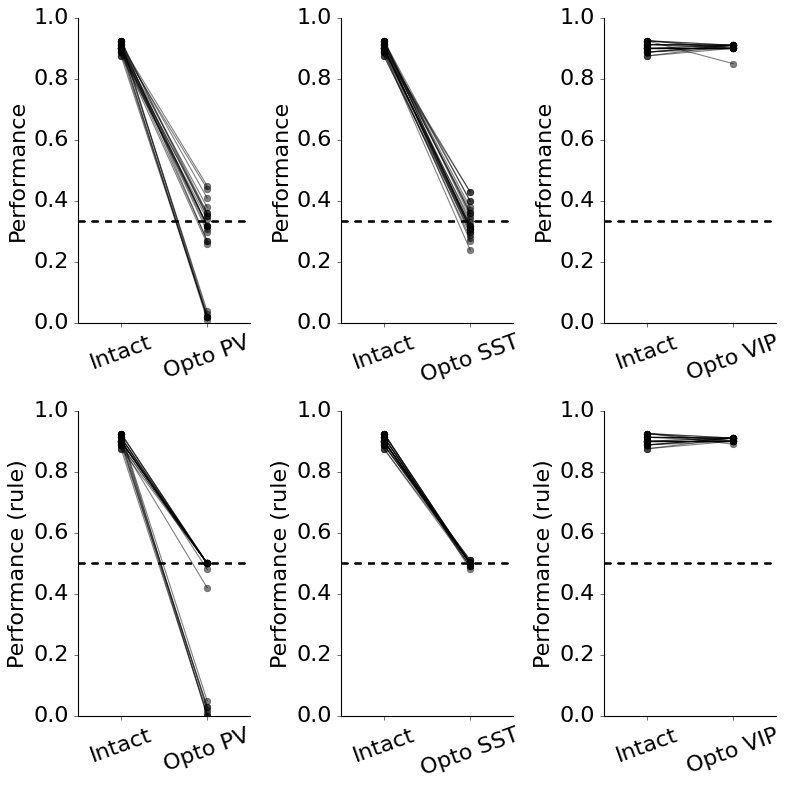

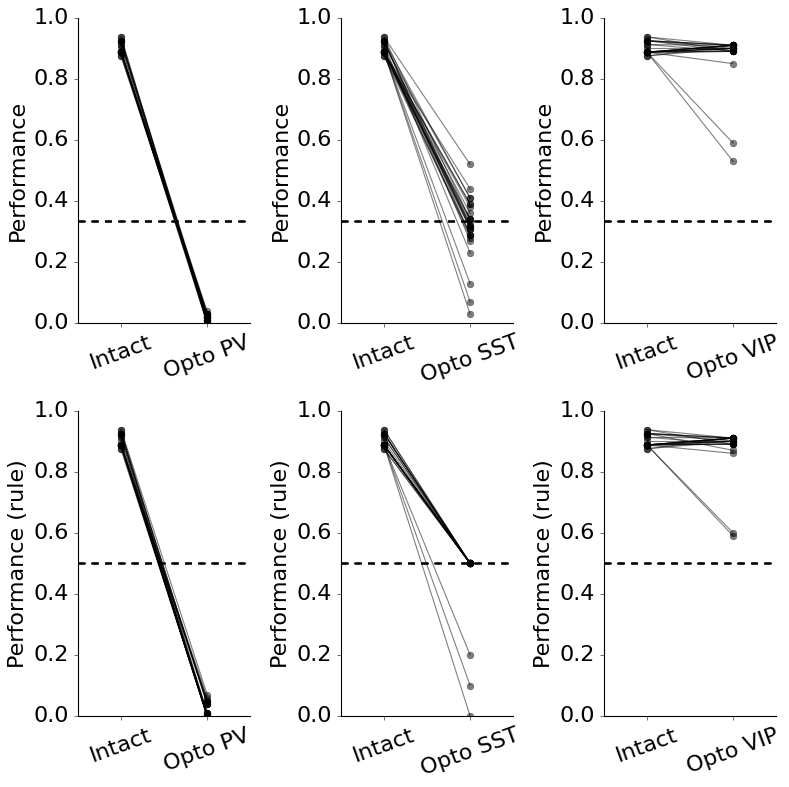

In [16]:
data_fig7e = {'intact': [], 'silence_sst': []}
data_suppfig11b = {'intact': [], 'silence_sst': []}
data_silencepv = {'intact': [], 'silence_pv': []}
data_silencevip = {'intact': [], 'silence_vip': []}

for dend_nonlinear in ['subtractive', 'divisive_2']:
    fig, ax = plt.subplots(2, 3, figsize=[10, 10])
    plt.style.use('classic')
    fig.patch.set_facecolor('white')
    for data in all_data_opto_perf:
        if data['hp']['dend_nonlinearity']!=dend_nonlinear:
            continue
        perf_intact = data['mean_perf_intact']
        perf_nosst = data['mean_perf_nosst']
        perf_novip = data['mean_perf_novip']
        perf_nopv = data['mean_perf_nopv']
        perf_rule_intact = data['mean_perf_rule_intact']
        perf_rule_nosst = data['mean_perf_rule_nosst']
        perf_rule_novip = data['mean_perf_rule_novip']
        perf_rule_nopv = data['mean_perf_rule_nopv']
        ax[0, 0].plot([perf_intact, perf_nopv], color='k', alpha=0.5, marker='o')
        ax[1, 0].plot([perf_rule_intact, perf_rule_nopv], color='k', alpha=0.5, marker='o')
        ax[0, 1].plot([perf_intact, perf_nosst], color='k', alpha=0.5, marker='o')
        ax[1, 1].plot([perf_rule_intact, perf_rule_nosst], color='k', alpha=0.5, marker='o')
        ax[0, 2].plot([perf_intact, perf_novip], color='k', alpha=0.5, marker='o')
        ax[1, 2].plot([perf_rule_intact, perf_rule_novip], color='k', alpha=0.5, marker='o')
    
    
        if data['hp']['dend_nonlinearity'] == 'subtractive':
            data_fig7e['intact'].append(perf_intact)
            data_fig7e['silence_sst'].append(perf_nosst)
        elif data['hp']['dend_nonlinearity'] == 'divisive_2':
            data_suppfig11b['intact'].append(perf_intact)
            data_suppfig11b['silence_sst'].append(perf_nosst)
        data_silencepv['intact'].append(perf_intact)
        data_silencepv['silence_pv'].append(perf_nopv)
        data_silencevip['intact'].append(perf_intact)
        data_silencevip['silence_vip'].append(perf_novip)
        
        for i in range(2):
            for j in range(3):
                ax[i, j].set_xticks([0, 1])
                if j==0:
                    ctype='PV'
                elif j==1:
                    ctype='SST'
                elif j==2:
                    ctype='VIP'
                ax[i, j].set_xticklabels(['Intact', 'Opto {}'.format(ctype)], rotation=20)
                ax[i, j].set_xlim([-0.5, 1.5])
                ax[i, j].set_ylim([0, 1])
                if i==0:
                    ax[i, j].axhline(y=1/3, linestyle='dashed', color='k')
                    ax[i, j].set_ylabel('Performance', fontsize=20)
                elif i==1:
                    ax[i, j].axhline(y=1/2, linestyle='dashed', color='k')
                    ax[i, j].set_ylabel('Performance (rule)', fontsize=20)
                make_pretty_axes(ax[i, j])
    fig.tight_layout()
    plt.show()
    

In [13]:
pd.DataFrame.from_dict(data=data_fig7e, orient='columns').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/fig7e.csv', header=False)
pd.DataFrame.from_dict(data=data_suppfig11b, orient='columns').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/suppfig11b.csv', header=False)
pd.DataFrame.from_dict(data=data_silencepv, orient='columns').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/silencepv.csv', header=False)
pd.DataFrame.from_dict(data=data_silencevip, orient='columns').to_csv('/home/yl4317/Documents/two_module_rnn/source_data/silencevip.csv', header=False)

# draft: mean rule selectivity in the sensorimotor exc neurons for different levels of dendritic coding

In [ ]:
xs = []
ys = []
fig, ax = plt.subplots(figsize=[4, 4])
for data in all_data_branch_coding:
    degree_branch_coding = np.abs(np.array(data['rule_sel_dend1']) - np.array(data['rule_sel_dend2']))
    degree_branch_coding = np.mean(degree_branch_coding)
    mean_rule_sel = np.abs(data['mean_rule_sel_all_sm_esoma_rule_cells'])
    ax.scatter(x=degree_branch_coding, y=mean_rule_sel, color='k')
    xs.append(degree_branch_coding)
    ys.append(mean_rule_sel)
ax.set_xlabel('diff in rule selectivity btw branches', fontsize=15)
ax.set_xlabel('mean rule selectivity', fontsize=15)
make_pretty_axes(ax)
plt.show()

print(stats.pearsonr(x=xs, y=ys))
    

In [ ]:
# plot sparsity instead of diff in rule selectivity

xs = []
ys = []
fig, ax = plt.subplots(figsize=[4, 4])
for data in all_data_branch_coding:
    if data['hp']['dend_nonlinearity']!='subtractive':
        continue
    print(data['hp']['initialization_weights'])
    mean_rule_sel = np.abs(data['mean_rule_sel_all_sm_esoma_rule_cells'])
    ax.scatter(x=data['hp']['sparse_srsst_to_sredend'], y=mean_rule_sel, color='k')
    xs.append(degree_branch_coding)
    ys.append(mean_rule_sel)
ax.set_xlabel('sparsity', fontsize=15)
ax.set_ylabel('mean rule selectivity', fontsize=15)
make_pretty_axes(ax)
plt.show()

print(stats.pearsonr(x=xs, y=ys))
    

# draft: overlap between the neural states of 2 rules in the sensorimotor exc neurons for different levels of dendritic coding

In [ ]:
xs = []
ys = []
fig, ax = plt.subplots(figsize=[4, 4])
for data in all_data_branch_coding:
    degree_branch_coding = np.abs(np.array(data['rule_sel_dend1']) - np.array(data['rule_sel_dend2']))
    degree_branch_coding = np.mean(degree_branch_coding)
    cos = np.abs(data['cosine'][0,0])
    ax.scatter(x=degree_branch_coding, y=cos, color='k')
    xs.append(degree_branch_coding)
    ys.append(cos)
make_pretty_axes(ax)
plt.show()

print(stats.pearsonr(x=xs, y=ys))
    

# Back of the envelop calculation
If there are N_1 SST rule 1 neurons, N_2 SST rule 2 neurons. They connect to exc neuron dendrites with probability p

The probability that each dendritic branch receives input from n_i SST rule i neurons is a binomial distribution: B(N_i, n_i, p)

Assume that the input from each SST neuron is the same, then the probability distribution of n_1 - n_2 describes the rule selectivity of the dendritic branch.

## First, get the distribution of SST->Edend weights in the model

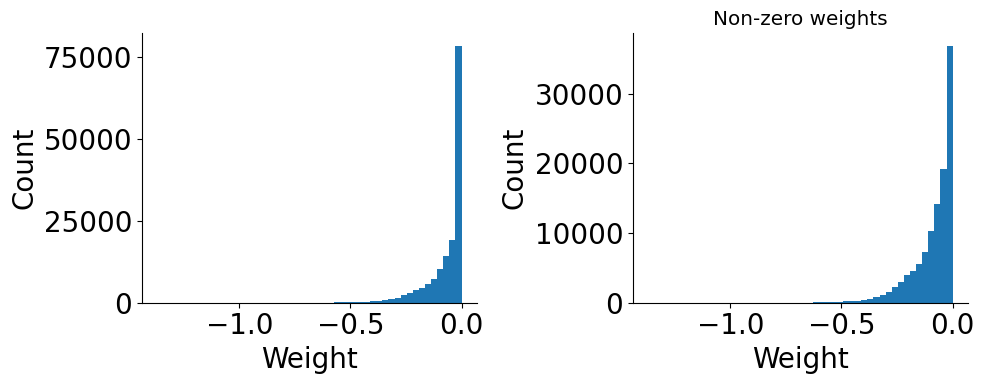

In [5]:
w_sst_edend_all = []
for data in all_data_branch_coding:
    model = data['model']
    w_rec_eff = model.rnn.effective_weight(w=model.rnn.w_rec, mask=model.rnn.mask, w_fix=model.rnn.w_fix).detach().cpu().numpy()
    w_sst_edend = w_rec_eff[np.ix_(model.rnn.cg_idx['sr_sst'], model.rnn.cg_idx['sr_edend'])]
    w_sst_edend = w_sst_edend.flatten()
    w_sst_edend_all.extend(w_sst_edend)
#     fig, ax = plt.subplots()
#     ax.hist(w_sst_edend, bins=50)
#     make_pretty_axes(ax)
#     plt.show()

fig, ax = plt.subplots(1, 2, figsize=[10, 4])
w_sst_edend_all_nonzero = [_ for _ in w_sst_edend_all if _!=0]
ax[0].hist(w_sst_edend_all, bins=50)
ax[1].hist(w_sst_edend_all_nonzero, bins=50)
ax[1].set_title('Non-zero weights')
for _ax in ax:
    make_pretty_axes(_ax)
    _ax.set_xlabel('Weight', fontsize=20)
    _ax.set_ylabel('Count', fontsize=20)
fig.tight_layout()
plt.show()

In [2]:
from scipy.stats import binom

n_samples = 10000
N1, N2 = 500, 500    # number of SST rule 1/2 neurons
# p = 0.2    # connection prob

fig, ax = plt.subplots(2, 4, figsize=[25, 10])

for sparsity in [0, 0.2, 0.5, 0.8]:
    p = 1-sparsity
    rule_sels_norm = dict.fromkeys(np.arange(2))
    rule_sels_unnorm = dict.fromkeys(np.arange(2))
    for branch in rule_sels_norm.keys():
        n1, n2 = np.random.binomial(n=N1, p=p, size=n_samples), np.random.binomial(n=N2, p=p, size=n_samples)
        
#         w1, w2 = np.random.uniform(low=0, high=1, size=n_samples), np.random.uniform(low=0, high=1, size=n_samples)
        w1, w2 = 1, 1 
#         w1, w2 = np.random.normal(loc=0, scale=0.2, size=n_samples), np.random.normal(loc=0, scale=0.2, size=n_samples)
#         w1, w2 = random.sample(w_sst_edend_all_nonzero, n_samples), random.sample(w_sst_edend_all_nonzero, n_samples)    # should sample from the nonzero part of the distribution!
#         w1, w2 = np.abs(w1), np.abs(w2)
        
#         act_rule1 = np.tanh(0.2-w1*n1)
#         act_rule2 = np.tanh(0.2-w2*n2)
        act_rule1 = (w1*n1)
        act_rule2 = (w2*n2)
        
        rule_sels_unnorm[branch] = act_rule1 - act_rule2
        rule_sels_norm[branch] = np.asarray([(act_rule1[i]-act_rule2[i])/(act_rule1[i]+act_rule2[i]) if act_rule1[i]+act_rule2[i]!=0 else 0 for i in range(len(act_rule1))])
        
    diff_rule_sel_norm = np.abs(rule_sels_norm[0] - rule_sels_norm[1])
    diff_rule_sel_unnorm = np.abs(rule_sels_unnorm[0] - rule_sels_unnorm[1])
    
    ax[0, 0].hist(n1, label='sparsity {:.2f}'.format(1-p), alpha=0.5, bins=50)
    ax[0, 1].hist(w1, label='sparsity {:.2f}'.format(1-p), alpha=0.5, bins=50, histtype='step')
    ax[0, 2].hist(act_rule1, label='sparsity {:.2f}'.format(1-p), alpha=1, bins=50, histtype='step')
    ax[0, 3].hist(rule_sels_unnorm[0], label='sparsity {:.2f}'.format(1-p), alpha=1, bins=50, histtype='step')
    ax[1, 0].hist(diff_rule_sel_unnorm, label='sparsity {:.2f}'.format(1-p), alpha=1, bins=50, histtype='step')
    ax[1, 1].hist(rule_sels_norm[0], label='sparsity {:.2f}'.format(1-p), alpha=1, bins=50, histtype='step')
    ax[1, 2].hist(diff_rule_sel_norm, label='sparsity {:.2f}'.format(1-p), alpha=1, bins=50, histtype='step', density=True)
    ax[1, 3].errorbar(x=sparsity, y=np.mean(diff_rule_sel_norm), yerr=0, marker='o', color='k')
    
ax[0, 0].set_xlabel('# of connecting SST neurons \n for each rule', fontsize=20)
ax[0, 1].set_xlabel('Weight from SST neurons to Edend', fontsize=20)
ax[0, 2].set_xlabel('Activity', fontsize=20)
ax[0, 3].set_xlabel('Rule selectivity (un-normalized)', fontsize=20) 
ax[1, 0].set_xlabel('Difference of rule selectivity \n between branches (un-normalized)', fontsize=20)
ax[1, 1].set_xlabel('Rule selectivity (normalized)', fontsize=20) 
ax[1, 2].set_xlabel('Difference of rule selectivity \n between branches (normalized)', fontsize=20)
ax[1, 3].set_xlabel('Sparsity', fontsize=20)
ax[1, 3].set_ylabel('Difference of rule selectivity \n between branches (normalized)', fontsize=20)
# ax[1, 3].set_xlim([0.9, 1])

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i, j].legend(fontsize=10)
        make_pretty_axes(ax[i, j])

fig.tight_layout()
plt.show()

NameError: name 'plt' is not defined

# Compare to model

In [ ]:
all_sparsity = [0, 0.2, 0.5, 0.8]

act_rule1_all = dict.fromkeys(all_sparsity)
act_rule2_all = dict.fromkeys(all_sparsity)
rule_sel_unnorm_1_all = dict.fromkeys(all_sparsity) 
rule_sel_unnorm_2_all = dict.fromkeys(all_sparsity)
rule_sel_norm_1_all = dict.fromkeys(all_sparsity) 
rule_sel_norm_2_all = dict.fromkeys(all_sparsity) 
diff_rule_sel_unnorm_all = dict.fromkeys(all_sparsity) 
diff_rule_sel_norm_all = dict.fromkeys(all_sparsity)

for sparsity in [0, 0.2, 0.5, 0.8]:
#     if sparsity!=0.8:
#         continue
    act_rule1_all[sparsity] = []
    act_rule2_all[sparsity] = []
    rule_sel_unnorm_1_all[sparsity] = []
    rule_sel_unnorm_2_all[sparsity] = []
    rule_sel_norm_1_all[sparsity] = []
    rule_sel_norm_2_all[sparsity] = []
    diff_rule_sel_unnorm_all[sparsity] = []
    diff_rule_sel_norm_all[sparsity] = []
    
    for data in all_data_branch_coding:
        if data['hp']['sparse_srsst_to_sredend']!=sparsity:
            continue
#         if data['hp']['dend_nonlinearity']!='subtractive_3' and data['hp']['dend_nonlinearity']!='divisive' and data['hp']['dend_nonlinearity']!='subtractive_rectified':
#             continue
        act_rule1 = np.asarray([data['all_sels']['act_rule1'][n] for n in data['dend1_idx']])
        act_rule2 = np.asarray([data['all_sels']['act_rule2'][n] for n in data['dend1_idx']])
        rule_sel_unnorm_1 = np.asarray([data['all_sels']['rule_activity'][n] for n in data['dend1_idx']])
        rule_sel_unnorm_2 = np.asarray([data['all_sels']['rule_activity'][n] for n in data['dend2_idx']])
        rule_sel_norm_1 = np.asarray([data['all_sels']['rule_normalized_activity'][n] for n in data['dend1_idx']])
        rule_sel_norm_2 = np.asarray([data['all_sels']['rule_normalized_activity'][n] for n in data['dend2_idx']])
        diff_rule_sel_unnorm = np.abs(rule_sel_unnorm_1 - rule_sel_unnorm_2)
        diff_rule_sel_norm = np.abs(rule_sel_norm_1 - rule_sel_norm_2)
        
        act_rule1_all[sparsity].extend(act_rule1)
        act_rule2_all[sparsity].extend(act_rule2)
        rule_sel_unnorm_1_all[sparsity].extend(rule_sel_unnorm_1)
        rule_sel_unnorm_2_all[sparsity].extend(rule_sel_unnorm_2)
        rule_sel_norm_1_all[sparsity].extend(rule_sel_norm_1)
        rule_sel_norm_2_all[sparsity].extend(rule_sel_norm_2)
        diff_rule_sel_unnorm_all[sparsity].extend(diff_rule_sel_unnorm)
        diff_rule_sel_norm_all[sparsity].extend(diff_rule_sel_norm)
        
        fig, ax = plt.subplots(2, 4, figsize=[20, 8])
        fig.suptitle(sparsity, fontsize=30)
        ax[0, 0].hist(act_rule1)
        ax[0, 1].hist(act_rule2)
        ax[0, 2].hist(rule_sel_unnorm_1)
        ax[0, 3].hist(rule_sel_unnorm_2)
        ax[1, 0].hist(rule_sel_norm_1)
        ax[1, 1].hist(rule_sel_norm_2)
        ax[1, 2].hist(diff_rule_sel_unnorm)
        ax[1, 3].hist(diff_rule_sel_norm)
        ax[0, 0].set_xlabel('Activity during rule 1', fontsize=15)
        ax[0, 1].set_xlabel('Activity during rule 2', fontsize=15)
        ax[0, 2].set_xlabel('Unnormalized rule selectivity \n for branch 1', fontsize=15)
        ax[0, 3].set_xlabel('Unnormalized rule selectivity \n for branch 2', fontsize=15)
        ax[1, 0].set_xlabel('Normalized rule selectivity \n for branch 1', fontsize=15)
        ax[1, 1].set_xlabel('Normalized rule selectivity \n for branch 2', fontsize=15)
        ax[1, 2].set_xlabel('Difference in the unnormalized rule sel', fontsize=15)
        ax[1, 3].set_xlabel('Difference in the normalized rule sel', fontsize=15)
        
        for i in range(2):
            for j in range(4):
                make_pretty_axes(ax[i, j])
        
        fig.tight_layout()
        plt.show()
        
        
        


In [ ]:
fig, ax = plt.subplots(3, 4, figsize=[20, 12])
for sparsity in all_sparsity:
    ax[0, 0].hist(act_rule1_all[sparsity], alpha=1, histtype='step', label='sparsity {}'.format(sparsity), bins=50, density=True)
    ax[0, 1].hist(act_rule2_all[sparsity], alpha=1, histtype='step', label='sparsity {}'.format(sparsity), bins=50, density=True)
    ax[0, 2].hist(rule_sel_unnorm_1_all[sparsity], alpha=1, histtype='step', label='sparsity {}'.format(sparsity), bins=50, density=True)
    ax[0, 3].hist(rule_sel_unnorm_2_all[sparsity], alpha=1, histtype='step', label='sparsity {}'.format(sparsity), bins=50, density=True)
    ax[1, 0].hist(rule_sel_norm_1_all[sparsity], alpha=1, histtype='step', label='sparsity {}'.format(sparsity), bins=50, density=True)
    ax[1, 1].hist(rule_sel_norm_2_all[sparsity], alpha=1, histtype='step', label='sparsity {}'.format(sparsity), bins=50, density=True)
    ax[1, 2].hist(diff_rule_sel_unnorm_all[sparsity], alpha=1, histtype='step', label='sparsity {}'.format(sparsity), bins=50, density=True)
    ax[1, 3].hist(diff_rule_sel_norm_all[sparsity], alpha=1, histtype='step', label='sparsity {}, {:.4f}'.format(sparsity, np.mean(diff_rule_sel_norm_all[sparsity])), bins=50, density=True)
    ax[2, 0].errorbar(x=sparsity, y=np.mean(diff_rule_sel_norm_all[sparsity]), marker='o', color='k')
ax[0, 0].set_xlabel('Activity during rule 1', fontsize=15)
ax[0, 1].set_xlabel('Activity during rule 2', fontsize=15)
ax[0, 2].set_xlabel('Unnormalized rule selectivity \n for branch 1', fontsize=15)
ax[0, 3].set_xlabel('Unnormalized rule selectivity \n for branch 2', fontsize=15)
ax[1, 0].set_xlabel('Normalized rule selectivity \n for branch 1', fontsize=15)
ax[1, 1].set_xlabel('Normalized rule selectivity \n for branch 2', fontsize=15)
ax[1, 2].set_xlabel('Difference in the unnormalized rule sel', fontsize=15)
ax[1, 3].set_xlabel('Difference in the normalized rule sel', fontsize=15)
ax[2, 0].set_xlabel('Sparsity', fontsize=15)
ax[2, 0].set_ylabel('Difference in rule \n selectivity across branches', fontsize=15)

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        make_pretty_axes(ax[i, j])
        ax[i, j].legend(fontsize=10)
        make_pretty_axes(ax[i, j])
fig.tight_layout()
plt.show()